In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier
import statsmodels.api as sm
from xgboost import XGBRegressor

In [2]:
df_holidays = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_stores = pd.read_csv('stores.csv')
df_trans = pd.read_csv('transactions.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
#datetime形に変換
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] =  pd.to_datetime(df_oil['date'])
df_trans['date'] =  pd.to_datetime(df_trans['date'])
df_train['date'] =  pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [4]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [8]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


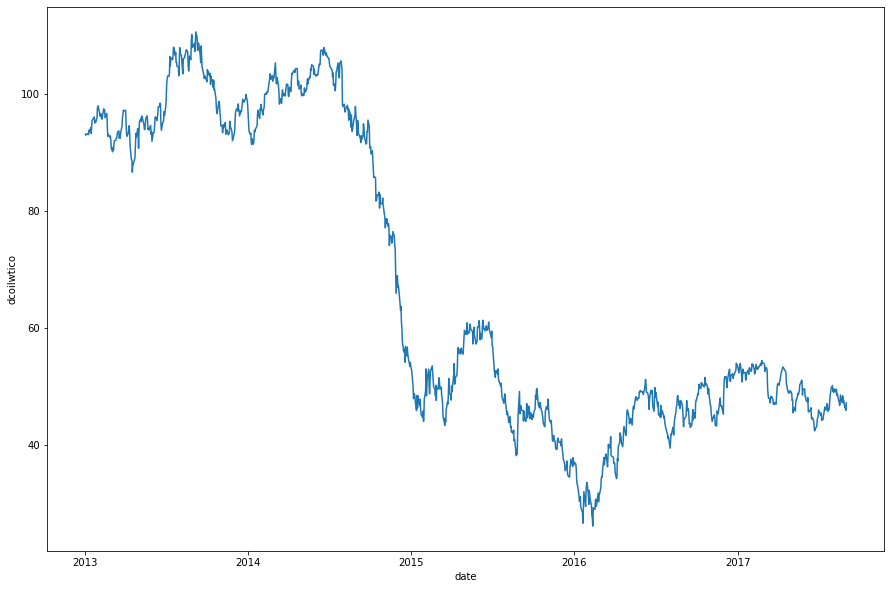

In [9]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='dcoilwtico', data=df_oil)
plt.show()

In [10]:
df_train.query('date=="2013-01-06"')['sales'].mean()

291.6360275465768

## 日にちでsalesを合計：週や月も後でまとめてみたい

In [11]:
df_sum=df_train.groupby('date').agg({'sales':'sum'}).reset_index()
df_sum.head(7)

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
5,2013-01-06,519695.401088
6,2013-01-07,336122.801066


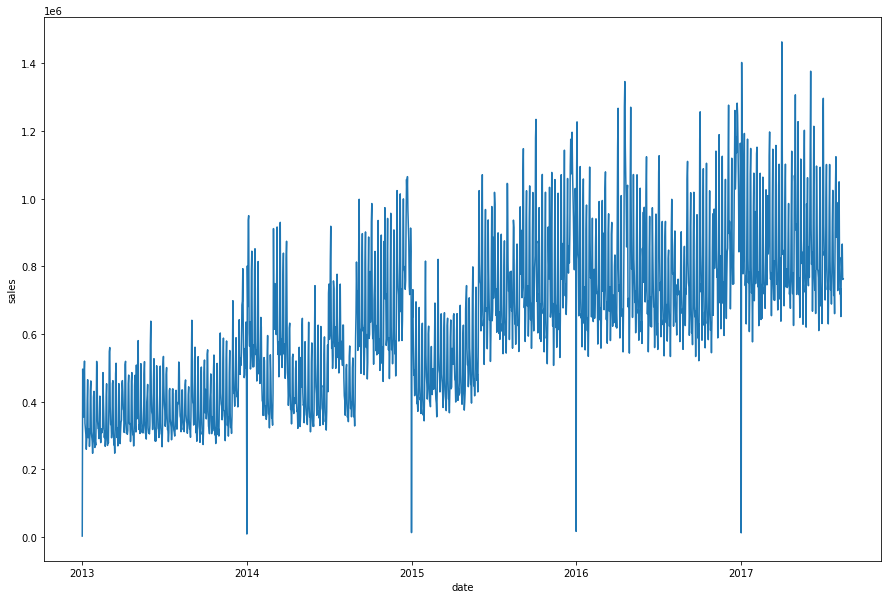

In [12]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='sales', data=df_sum)
plt.show()

In [13]:
#タイムダミーを作成
df_sum['time']= np.arange(len(df_sum.index))
df_sum

,date,sales,time
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,1
2,2013-01-03,361461.231124,2
3,2013-01-04,354459.677093,3
4,2013-01-05,477350.121229,4
...,...,...,...
1679,2017-08-11,826373.722022,1679
1680,2017-08-12,792630.535079,1680
1681,2017-08-13,865639.677471,1681
1682,2017-08-14,760922.406081,1682


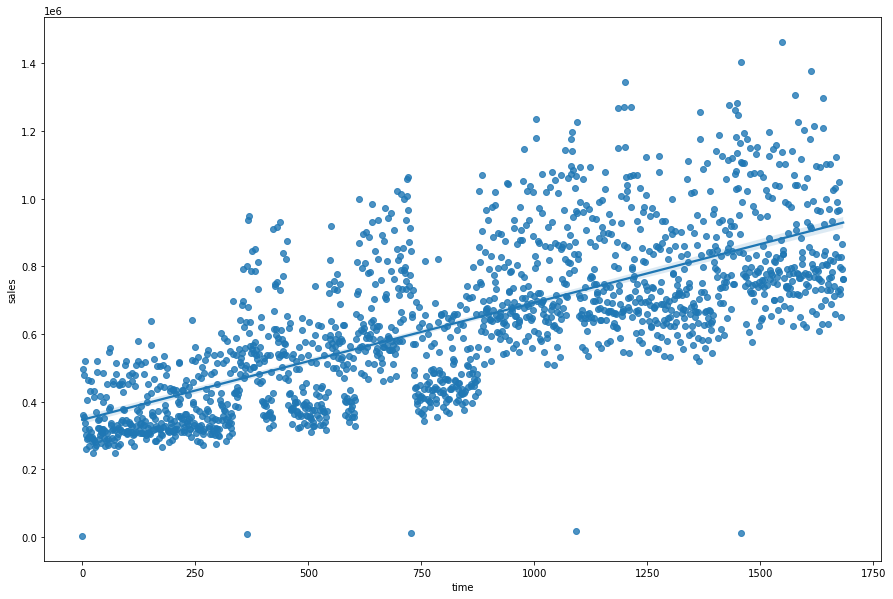

In [14]:
plt.figure(figsize=(15,10))
sns.regplot(x='time', y='sales', data=df_sum)
plt.show()

In [15]:
#タイムダミーを特徴量にsalesを目的変数として線形回帰
#Xはloc[:,['time']]
#yはloc[:,'sales']にしないとこのセルは実行されない
X=df_sum.loc[:,['time']]
y=df_sum.loc[:,'sales']

LR=LinearRegression()
LR.fit(X,y)
print(LR.intercept_,LR.coef_)
y_pred=pd.Series(LR.predict(X), index=X.index)
y_pred

346122.8320909401 [346.32626599]


0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

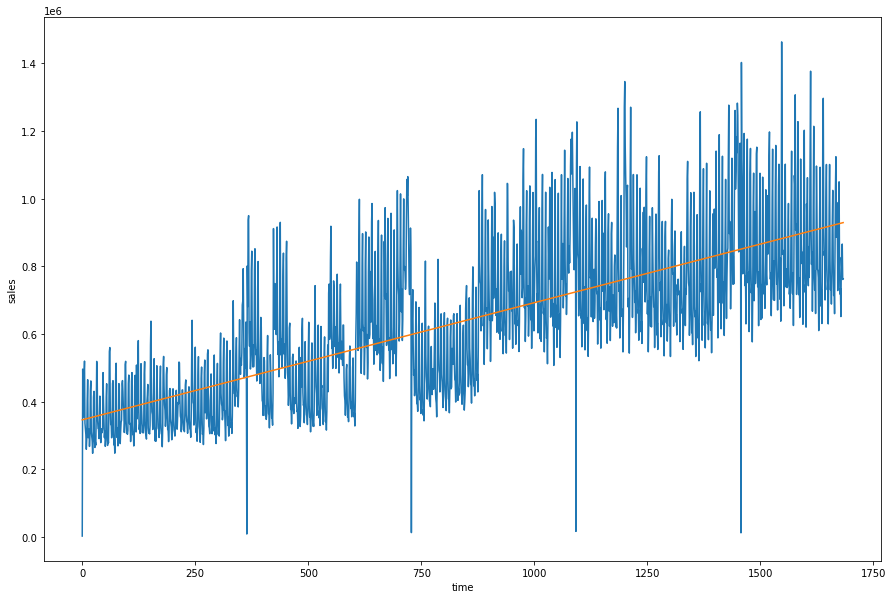

In [16]:
#もとの時系列データを回帰直線をプロット
plt.figure(figsize=(15,10))
sns.lineplot(x='time', y='sales', data=df_sum)
y_pred.plot()
plt.show()

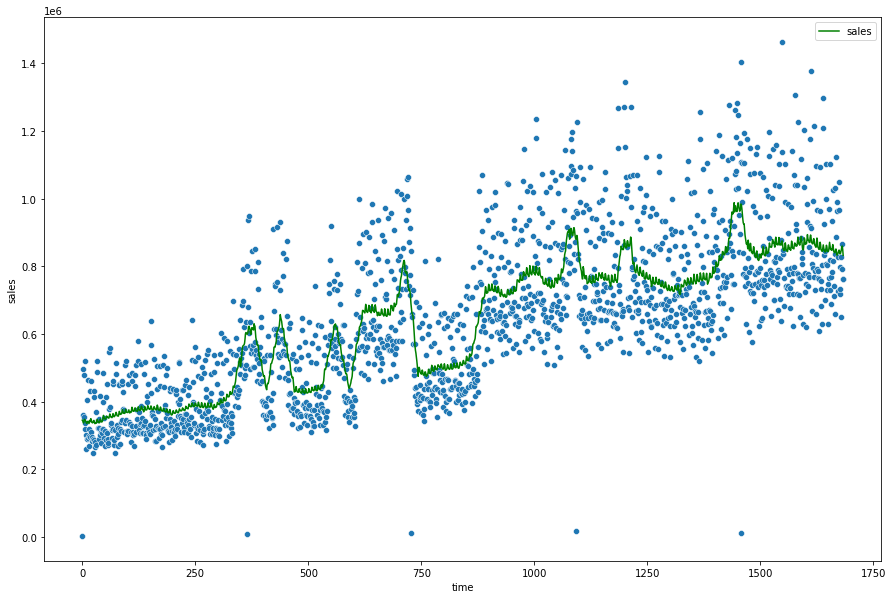

0       345177.747714
1       343500.883104
2       339030.155626
3       336646.860870
4       341689.649878
            ...      
1679    848509.631730
1680    858439.095134
1681    859735.729185
1682    849584.250565
1683    832448.736353
Name: sales, Length: 1684, dtype: float64

In [17]:
#30日移動平均線⇒右上がりなのが分かる⇒一次式で近似、予測？
moving_avg = df_sum['sales'].rolling(window=30, center=True, min_periods=15).mean()
fig, ax=plt.subplots(figsize=(15,10))
ax=sns.scatterplot(x='time', y='sales', data=df_sum)
moving_avg.plot(color='g', ax=ax)
plt.legend()
plt.show()
display(moving_avg)

In [18]:
#DeterministicProcessを使ってトレンドを線形回帰で予測（さっきやったけど）
#タイムダミー特徴量作成
from statsmodels.tsa.deterministic import DeterministicProcess

dp=DeterministicProcess(index=df_sum.index, constant=True, order=1, drop=True)
X=dp.in_sample()
X

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
1679,1.0,1680.0
1680,1.0,1681.0
1681,1.0,1682.0
1682,1.0,1683.0


In [19]:
from sklearn.linear_model import LinearRegression
model=LinearRegression(fit_intercept=False)
y=df_sum['sales']
model.fit(X,y)

LinearRegression(fit_intercept=False)

In [20]:
#indexを'date'にしておくのかなり重要（あとでこっちのほうが良いと感じる）
#上の作業は絶対にしてはいけない
y_pred1=pd.Series(model.predict(X), index=y.index)
y_pred1

0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

In [21]:
df_sum

,date,sales,time
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,1
2,2013-01-03,361461.231124,2
3,2013-01-04,354459.677093,3
4,2013-01-05,477350.121229,4
...,...,...,...
1679,2017-08-11,826373.722022,1679
1680,2017-08-12,792630.535079,1680
1681,2017-08-13,865639.677471,1681
1682,2017-08-14,760922.406081,1682


## 30日後の予測を行う

In [22]:
#30日先のデータ作成
X = dp.out_of_sample(steps=30)
#30日先を予測
y_fore = pd.Series(model.predict(X), index=X.index)
X['forecast'] = y_fore
display(X)

,const,trend,forecast
1684,1.0,1685.0,929336.264012
1685,1.0,1686.0,929682.590278
1686,1.0,1687.0,930028.916544
1687,1.0,1688.0,930375.242810
1688,1.0,1689.0,930721.569076
1689,1.0,1690.0,931067.895342
1690,1.0,1691.0,931414.221608
1691,1.0,1692.0,931760.547874
1692,1.0,1693.0,932106.874140
1693,1.0,1694.0,932453.200406


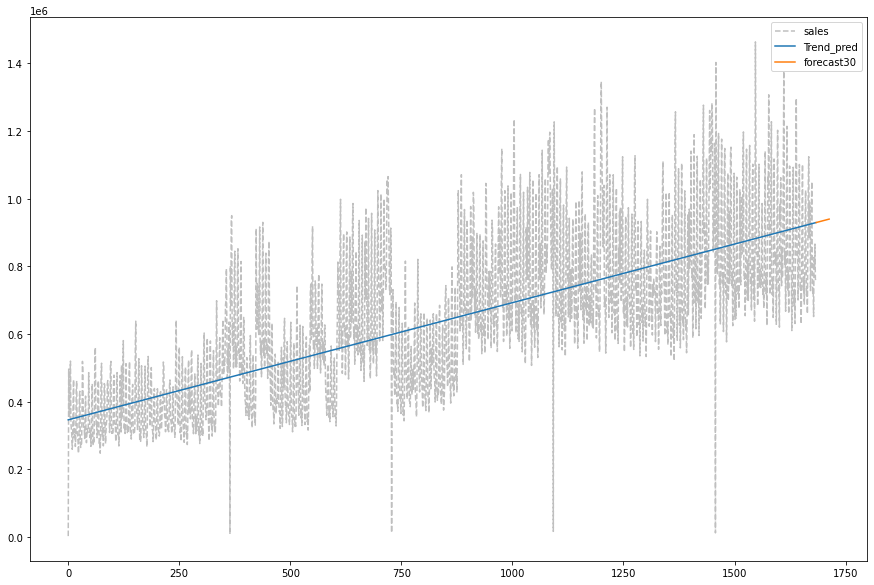

In [23]:
#30日後を予測したグラフ
fig, ax=plt.subplots(figsize=(15,10))
df_sum.plot(y='sales',linestyle='dashed',color="0.75",ax=ax)
y_pred1.plot(label="Trend_pred",ax=ax)
y_fore.plot(ax=ax, label='forecast30')
plt.legend()

## 季節性

In [24]:
#df_sumを新しいXに格納
X=df_sum.copy()
X=X.set_index('date')
#'time'いらないからなくす
X=X.drop('time', axis=1)
display(X)
X['dayofweek']= X.index.dayofweek
X['week'] = X.index.week
X['dayofyear']=X.index.dayofyear
X['year']=X.index.year
X

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


C:\Users\macch\AppData\Local\Temp/ipykernel_5968/1133008777.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X['week'] = X.index.week


,sales,dayofweek,week,dayofyear,year
date,,,,,
2013-01-01,2511.618999,1,1,1,2013
2013-01-02,496092.417944,2,1,2,2013
2013-01-03,361461.231124,3,1,3,2013
2013-01-04,354459.677093,4,1,4,2013
2013-01-05,477350.121229,5,1,5,2013
...,...,...,...,...,...
2017-08-11,826373.722022,4,32,223,2017
2017-08-12,792630.535079,5,32,224,2017
2017-08-13,865639.677471,6,32,225,2017


### 季節性プロットをする

Text(0.5, 1.0, 'seasonalplot (year/dayofyear)')

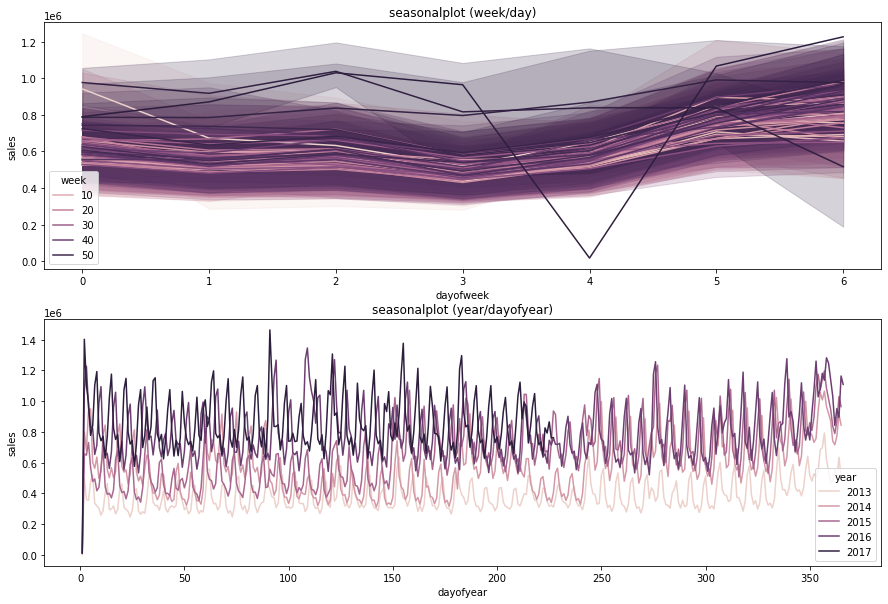

In [25]:
fig, (ax0,ax1)=plt.subplots(2,1,figsize=(15,10))
sns.lineplot(x='dayofweek',y='sales', data=X, ax=ax0, hue='week' )
ax0.set_title('seasonalplot (week/day)')
sns.lineplot(x='dayofyear', y='sales', data=X, ax=ax1, hue='year')
ax1.set_title('seasonalplot (year/dayofyear)')

## ピリオドグラムをプロット

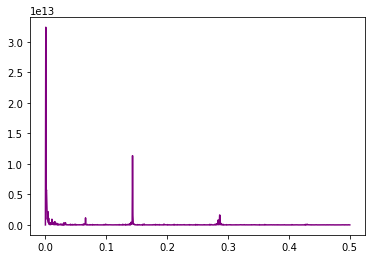

In [26]:
from scipy.signal import periodogram

#fs = pd.Timedelta("365D") / pd.Timedelta("1D")
f, spec = periodogram(X['sales'])
plt.plot(f, spec, color="purple")


In [27]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

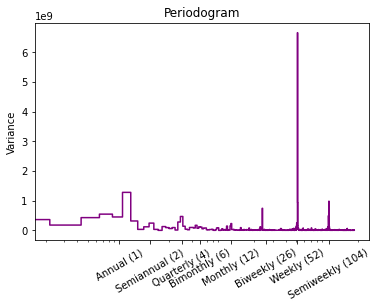

In [28]:
plot_periodogram(ts=X['sales'])

## 季節性をモデル化して予測しよう

In [29]:
#DeterministicProcess(index=df_sum,は１次元配列でないとダメなので作り直し
#もう一度df_sumを作り直し
df_sum=df_train.groupby('date').agg({'sales':'sum'})
#ここで必ず.to_period('Dを加えて変換すること！！')そうしないとDeterministicProcessが受け付けない
df_sum=df_sum.to_period('D')
df_sum.head(7)

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
2013-01-06,519695.401088
2013-01-07,336122.801066


In [30]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   1684 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [31]:
#特徴量作成
from statsmodels.tsa.deterministic import CalendarFourier
# 10 sin/cos pairs for "A"nnual seasonality
fourier = CalendarFourier(freq='A', order=10)

dp=DeterministicProcess(index=df_sum.index, constant=True,  order=1, seasonal=True, additional_terms=[fourier], drop=True)

### 特徴量作成と線形回帰での予測（季節性）

In [32]:
# create features for dates in tunnel.index
X=dp.in_sample()
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,...,-0.806480,-0.591261,0.998880,-0.047321,-0.746972,0.664855,0.162807,-0.986658,0.493776,0.869589
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,...,-0.863142,-0.504961,0.985948,-0.167052,-0.648630,0.761104,0.008607,-0.999963,0.635432,0.772157
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,...,-0.910605,-0.413279,0.958718,-0.284359,-0.538005,0.842942,-0.145799,-0.989314,0.758306,0.651899


In [33]:
y=df_sum['sales']
display(y)
#このモデルはXGBoostとかでもいいかもと思ったけどそれはこの先でやる
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
y_pred2=pd.Series(model.predict(X), index=y.index)

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1684, dtype: float64

### 90日後の予測値を作成

In [34]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_fore

2017-08-16    8.985779e+05
2017-08-17    8.464121e+05
2017-08-18    8.086022e+05
2017-08-19    8.346422e+05
2017-08-20    8.997903e+05
                  ...     
2017-11-09    9.580241e+05
2017-11-10    9.170420e+05
2017-11-11    9.389605e+05
2017-11-12    9.991162e+05
2017-11-13    1.028587e+06
Freq: D, Length: 90, dtype: float64

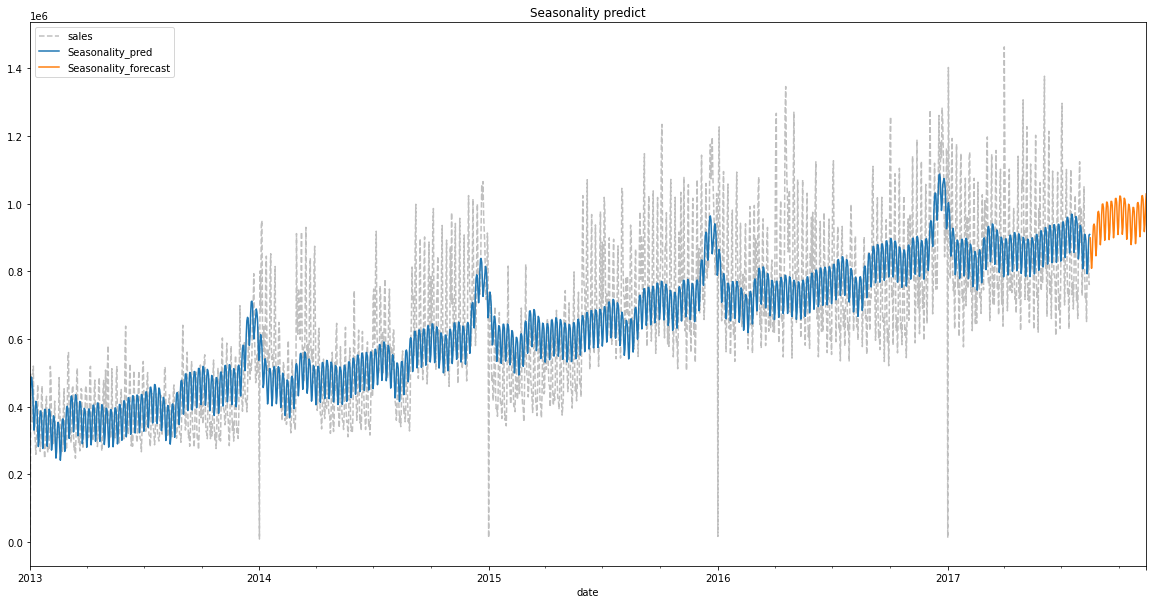

In [35]:
#90日分の予測値をプロット
fig, ax = plt.subplots(figsize=(20,10))
df_sum.plot(linestyle='dashed',color="0.75",ax=ax)
y_pred2.plot(ax=ax,label="Seasonality_pred")
y_fore.plot(ax=ax, label='Seasonality_forecast')
ax.set_title('Seasonality predict')
plt.legend()

## 4. Time Series as Features

### ラグ特徴量がこのあたりから出てくる

In [36]:
y

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1684, dtype: float64

In [37]:
#まずは残差を求めよう！
y=df_sum['sales']

y=y.reset_index().drop('date', axis=1)
display(y)
y_pred1=pd.DataFrame(y_pred1, columns=['sales'])
y_pred1

,sales
0,2511.618999
1,496092.417944
2,361461.231124
3,354459.677093
4,477350.121229
...,...
1679,826373.722022
1680,792630.535079
1681,865639.677471
1682,760922.406081


,sales
0,346122.832091
1,346469.158357
2,346815.484623
3,347161.810889
4,347508.137155
...,...
1679,927604.632682
1680,927950.958948
1681,928297.285214
1682,928643.611480


In [38]:
#残差
y_deseason=y - y_pred1
y_deseason

,sales
0,-343611.213092
1,149623.259587
2,14645.746501
3,7297.866204
4,129841.984074
...,...
1679,-101230.910660
1680,-135320.423870
1681,-62657.607743
1682,-167721.205400


<AxesSubplot:>

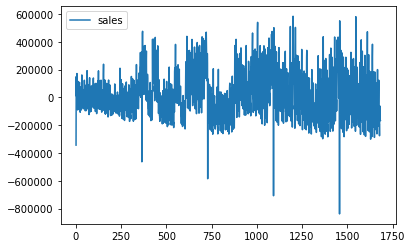

In [39]:
y_deseason.plot()

In [40]:
y_delag=y_deseason.copy()
y_delag['lag1'] = y_deseason.shift(1)
y_delag['lag8'] = y_deseason['sales'].shift(8)
y_delag['lag10']= y_deseason['sales'].shift(10)

In [41]:
y_delag

,sales,lag1,lag8,lag10
0,-343611.213092,NaN,NaN,NaN
1,149623.259587,-343611.213092,NaN,NaN
2,14645.746501,149623.259587,NaN,NaN
3,7297.866204,14645.746501,NaN,NaN
4,129841.984074,7297.866204,NaN,NaN
...,...,...,...,...
1679,-101230.910660,-275871.394447,-196765.537423,64386.393181
1680,-135320.423870,-101230.910660,-97404.662693,40224.319762
1681,-62657.607743,-135320.423870,40166.975405,-196765.537423
1682,-167721.205400,-62657.607743,123686.162924,-97404.662693


,sales,lag1,lag8,lag10
sales,1.000000,0.518507,0.339005,-0.073387
lag1,0.518507,1.000000,0.640981,-0.021224
lag8,0.339005,0.640981,1.000000,0.096504
lag10,-0.073387,-0.021224,0.096504,1.000000


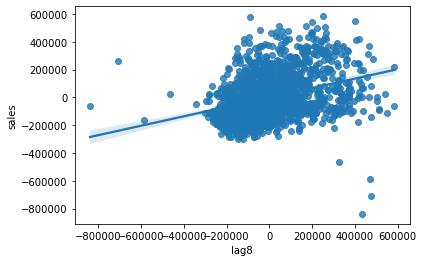

In [42]:
#ラグプロット
sns.regplot(x='lag8', y='sales', data=y_delag)
y_delag.corr()

In [43]:
y_deseason.shape

(1684, 1)

C:\Users\macch\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


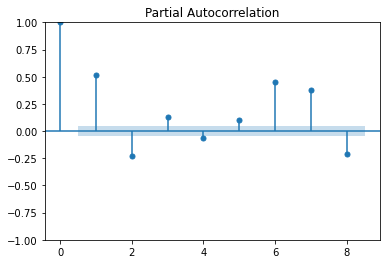

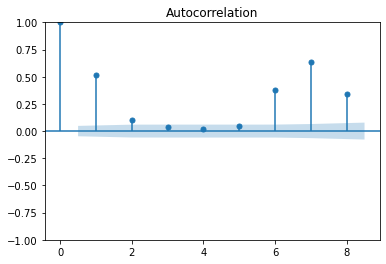

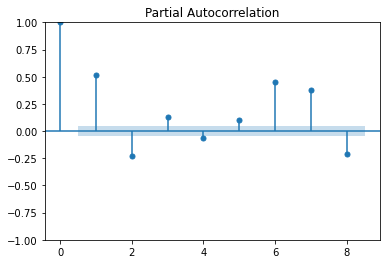

In [44]:
#自己相関と偏自己相関
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(y_deseason, lags=8)
sm.graphics.tsa.plot_pacf(y_deseason, lags=8)

In [45]:
#特徴量作成ののち予測
#1～4までを特徴量に
def make_lags(ts, lags):
    return pd.concat({
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1) }, axis=1)

X=make_lags(df_sum, 4)
X=X.fillna(0.0)
#配列に変換
X=X.values
X

array([[     0.       ,      0.       ,      0.       ,      0.       ],
       [  2511.618999 ,      0.       ,      0.       ,      0.       ],
       [496092.417944 ,   2511.618999 ,      0.       ,      0.       ],
       ...,
       [792630.5350785, 826373.722022 , 651386.9119697, 734139.67401  ],
       [865639.677471 , 792630.5350785, 826373.722022 , 651386.9119697],
       [760922.4060808, 865639.677471 , 792630.5350785, 826373.722022 ]])

## fit and predict(ラグ特徴量に対して）

In [46]:
y

,sales
0,2511.618999
1,496092.417944
2,361461.231124
3,354459.677093
4,477350.121229
...,...
1679,826373.722022
1680,792630.535079
1681,865639.677471
1682,760922.406081


In [47]:
# Create target series and data splits
y=y_deseason.copy()
# Fit and predict
model2=LinearRegression(fit_intercept=False)
model2.fit(X,y)
y_pred=pd.DataFrame(model2.predict(X), index=y.index, columns=['sales'])
y_pred

,sales
0,0.000000
1,1330.933381
2,261852.966107
3,-11944.783811
4,94238.627678
...,...
1679,-50831.297426
1680,95170.668585
1681,-7416.571746
1682,82805.670261


In [48]:
df_sum=df_train.groupby('date').agg({'sales':'sum'}).reset_index()
df_sum

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [49]:
#y_deseasonのインデックスにdf_sumのdateを割り当てる（y_predと比較するグラフを作成するときに日付で比較したいため）
df_sum2 = df_sum.copy()
display(df_sum2)
y_deseason_copy = y_deseason.copy()
y_deseason_copy['date'] =df_sum2['date']
y_deseason_copy=y_deseason_copy.set_index('date')
y_deseason_copy

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


,sales
date,
2013-01-01,-343611.213092
2013-01-02,149623.259587
2013-01-03,14645.746501
2013-01-04,7297.866204
2013-01-05,129841.984074
...,...
2017-08-11,-101230.910660
2017-08-12,-135320.423870
2017-08-13,-62657.607743


In [50]:
#y_predのインデックスにdf_sumのdateを割り当てる
y_pred['date'] = df_sum['date']
y_pred = y_pred.set_index('date')
y_pred

,sales
date,
2013-01-01,0.000000
2013-01-02,1330.933381
2013-01-03,261852.966107
2013-01-04,-11944.783811
2013-01-05,94238.627678
...,...
2017-08-11,-50831.297426
2017-08-12,95170.668585
2017-08-13,-7416.571746


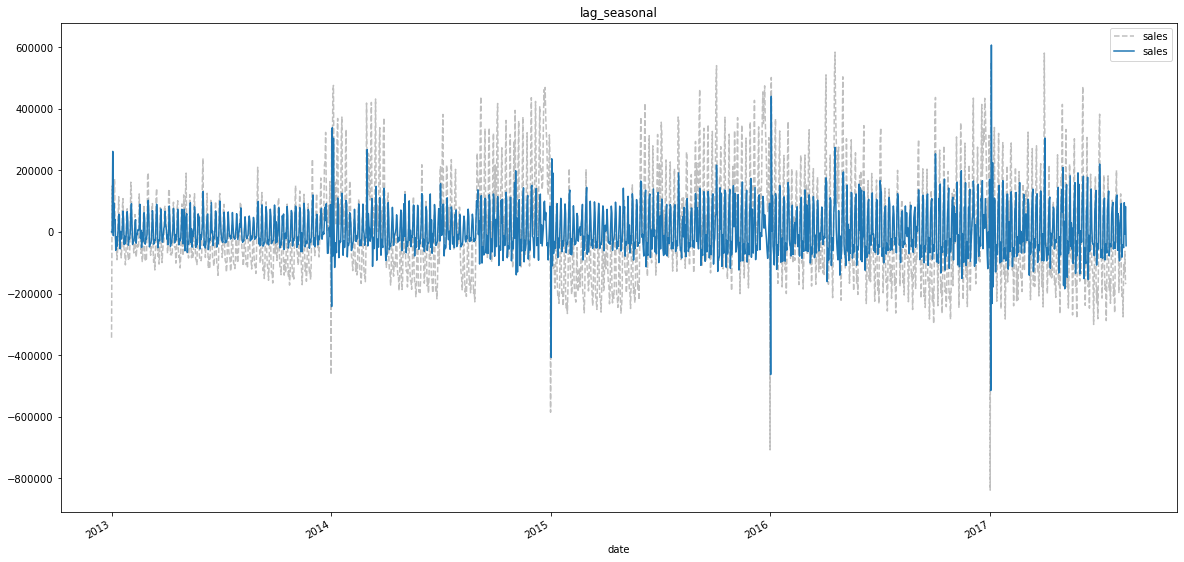

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
y_deseason_copy.plot(linestyle='dashed',color="0.75",ax=ax)
y_pred.plot(ax=ax,label="Seasonality_pred")
ax.set_title('lag_seasonal')
plt.legend()

<AxesSubplot:xlabel='date'>

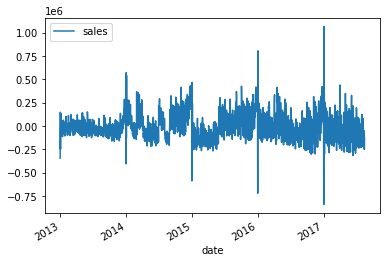

In [52]:
redi=y_deseason_copy - y_pred
redi.plot()

<AxesSubplot:xlabel='date'>

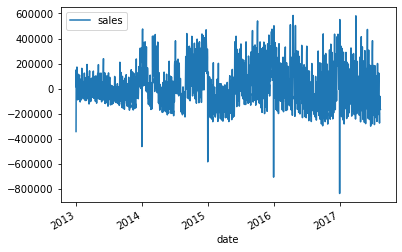

In [53]:
y_deseason_copy.plot()

<AxesSubplot:>

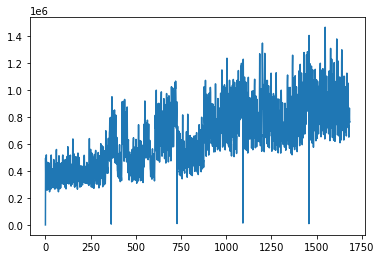

In [54]:
df_sum['sales'].plot()

# Hybrid Models

In [55]:
y_deseason_copy

,sales
date,
2013-01-01,-343611.213092
2013-01-02,149623.259587
2013-01-03,14645.746501
2013-01-04,7297.866204
2013-01-05,129841.984074
...,...
2017-08-11,-101230.910660
2017-08-12,-135320.423870
2017-08-13,-62657.607743


## 特徴量生成（XGB）

In [56]:
#トレンド予測
df_sum=df_train.groupby('date').agg({'sales':'sum'}).reset_index()
from statsmodels.tsa.deterministic import DeterministicProcess

dp=DeterministicProcess(index=df_sum.index, constant=True, order=1, drop=True)
X=dp.in_sample()

from sklearn.linear_model import LinearRegression
model=LinearRegression(fit_intercept=False)
y=df_sum['sales']
model.fit(X,y)

y_pred1=pd.Series(model.predict(X), index=y.index)
y_pred1

y_pred_1 = y_pred1.copy()
y_pred_1

0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

In [57]:
df_sum

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [58]:
df_sum['sales']

0         2511.618999
1       496092.417944
2       361461.231124
3       354459.677093
4       477350.121229
            ...      
1679    826373.722022
1680    792630.535079
1681    865639.677471
1682    760922.406081
1683    762661.935939
Name: sales, Length: 1684, dtype: float64

In [59]:
#目的変数作成
y_deseason_xgb = df_sum['sales'] - y_pred_1
display(y_deseason_xgb)
#indexをdateに
y_deseason_xgb.index = df_train.groupby('date').agg({'sales':'sum'}).index
display(y_deseason_xgb)

0      -343611.213092
1       149623.259587
2        14645.746501
3         7297.866204
4       129841.984074
            ...      
1679   -101230.910660
1680   -135320.423870
1681    -62657.607743
1682   -167721.205400
1683   -166328.001807
Length: 1684, dtype: float64

date
2013-01-01   -343611.213092
2013-01-02    149623.259587
2013-01-03     14645.746501
2013-01-04      7297.866204
2013-01-05    129841.984074
                  ...      
2017-08-11   -101230.910660
2017-08-12   -135320.423870
2017-08-13    -62657.607743
2017-08-14   -167721.205400
2017-08-15   -166328.001807
Length: 1684, dtype: float64

In [60]:
y_deseason_copy

,sales
date,
2013-01-01,-343611.213092
2013-01-02,149623.259587
2013-01-03,14645.746501
2013-01-04,7297.866204
2013-01-05,129841.984074
...,...
2017-08-11,-101230.910660
2017-08-12,-135320.423870
2017-08-13,-62657.607743


In [61]:
#XGB用の特徴量を作成
df_sum_pre = df_sum.set_index('date')
df_sum_pre['dayofyear'] = df_sum_pre.index.dayofyear
X_1=df_sum_pre
X_1

,sales,dayofyear
date,,
2013-01-01,2511.618999,1
2013-01-02,496092.417944,2
2013-01-03,361461.231124,3
2013-01-04,354459.677093,4
2013-01-05,477350.121229,5
...,...,...
2017-08-11,826373.722022,223
2017-08-12,792630.535079,224
2017-08-13,865639.677471,225


In [62]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_1, y_deseason_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [63]:
#予測値を算出（XGB）
y_pred_xgb = pd.Series(xgb.predict(X_1), index=X_1.index)
y_pred_xgb

date
2013-01-01   -344484.312500
2013-01-02    136594.406250
2013-01-03     15176.704102
2013-01-04      3279.194824
2013-01-05    112034.304688
                  ...      
2017-08-11    -61699.238281
2017-08-12   -105376.351562
2017-08-13    -13373.166992
2017-08-14   -112167.320312
2017-08-15   -105889.328125
Length: 1684, dtype: float32

<AxesSubplot:xlabel='date'>

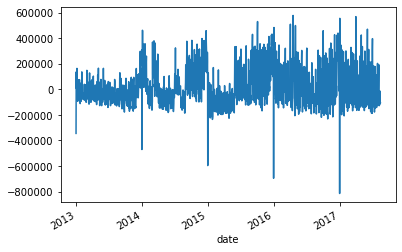

In [64]:
y_pred_xgb.plot()

## y_pred_1とy_pred_xgbを足す

In [65]:
#下で足しやすいようにindex=dateにする
y_pred_1.index=df_train.groupby('date').agg({'sales':'sum'}).index

In [66]:
#足す
y_pred_boosted = y_pred_xgb + y_pred_1
y_pred_boosted

date
2013-01-01      1638.519591
2013-01-02    483063.564607
2013-01-03    361992.188724
2013-01-04    350441.005713
2013-01-05    459542.441842
                  ...      
2017-08-11    865905.394401
2017-08-12    822574.607386
2017-08-13    914924.118222
2017-08-14    816476.291168
2017-08-15    823100.609621
Length: 1684, dtype: float64

<AxesSubplot:xlabel='date'>

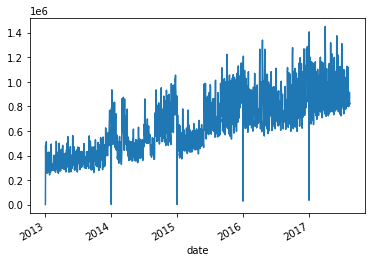

In [67]:
y_pred_boosted.plot()

In [68]:
#df_sumのindexをdate
df_sum_date = df_sum.copy().drop('date', axis=1)
df_sum_date.index = df_train.groupby('date').agg({'sales':'sum'}).index
df_sum_date

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


<AxesSubplot:xlabel='date'>

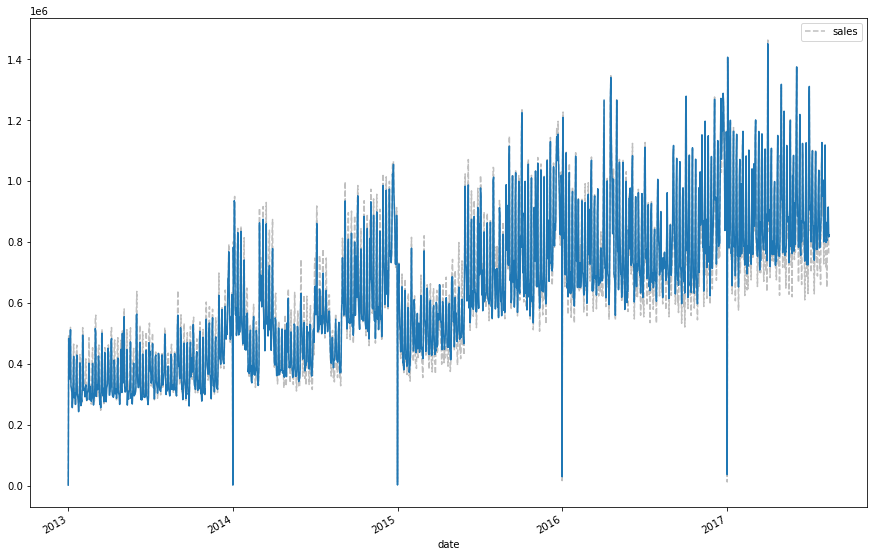

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
df_sum_date.plot(ax=ax,linestyle='dashed',color="0.75")
y_pred_boosted.plot(ax=ax)